In [12]:
s = 0
r = 1

In [2]:
s = int(s)
print(s)

0


In [3]:
!date

Tue Apr 26 12:47:45 EDT 2022


In [4]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [5]:
%%time
import numpy as np
import pandas as pd
import os
import ants
from matplotlib import pyplot as plt

#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm

CPU times: user 2.96 s, sys: 2.66 s, total: 5.62 s
Wall time: 13 s


In [8]:
indir = '~/data/sfari_bids/preprocessed/'
indir = os.path.expanduser(indir)

subjects = [subject for subject in os.listdir(indir) if subject.startswith('sub-')]
subjects.sort()
print(len(subjects))

188


In [9]:
prefs = ['frc','rc','sfrc']

In [10]:
pref = prefs[0]
sub = subjects[s]

In [32]:
def get_epi(sub):
    indir = '~/data/sfari_bids/preprocessed/'
    epi_path_temp = os.path.join(indir,sub,'{pref}-{subID}_run-{r}_bold.nii.gz')
    epi_path_temp = os.path.expanduser(epi_path_temp)
    print(epi_path_temp.format(pref='sfrc',subID=sub,r=r))
    im = ants.image_read(epi_path_temp.format(pref='sfrc',subID=sub,r=r))
    im = im.resample_image(resample_params=(64,64,64,im.shape[-1]), use_voxels=True, interp_type=4)
    return im

In [33]:
def get_cmat(im,atlas):
    
    rois = np.unique(atlas.numpy().flatten().astype(int))
    rois = rois[rois!=0]

    assert len(rois)==max(rois),'where rois?'
    
    im_arr = im.numpy().reshape(-1,im.shape[-1]).transpose()
    atlas_arr = atlas.flatten()

    roi_timeseries = np.array([im_arr[:,atlas_arr==r].mean(axis=1) for r in rois])

    assert np.isnan(roi_timeseries).sum()==0,'nans in timeseries'

    return np.corrcoef(roi_timeseries)

In [34]:
def get_cmat_split(im,atlas):
    
    rois = np.unique(atlas.numpy().flatten().astype(int))
    rois = rois[rois!=0]

    assert len(rois)==max(rois),'where rois?'
    

    im_arr = im.numpy().reshape(-1,im.shape[-1]).transpose()
    atlas_arr = atlas.flatten()
    
    n = im_arr.shape[0]
    mid = int(n/2)
    
    
    im_arr1 = im_arr[0:mid-2,:]
    im_arr2 = im_arr[mid+2::,:]

    roi_timeseries1 = np.array([im_arr1[:,atlas_arr==r].mean(axis=1) for r in rois])
    roi_timeseries2 = np.array([im_arr2[:,atlas_arr==r].mean(axis=1) for r in rois])

    cmat1 = np.corrcoef(roi_timeseries1)
    cmat2 = np.corrcoef(roi_timeseries2)
    
    return np.array([cmat1,cmat2])

In [35]:
im = get_epi(sub)
im3 = ants.slice_image(im,axis=3,idx=0)

/data/aglinska/data/sfari_bids/preprocessed/sub-001/sfrc-sub-001_run-1_bold.nii.gz


In [36]:
atlas = ants.image_read('../Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
atlas = atlas.resample_image_to_target(im3,interp_type='genericLabel')
#atlas = atlas.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

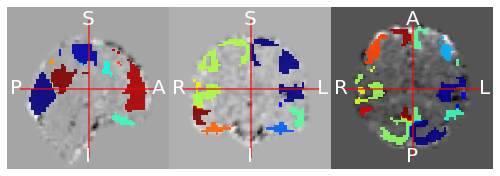

In [37]:
im3.plot_ortho(atlas,flat=True)

In [47]:
cmat = get_cmat(im,atlas)

In [38]:
cmats = get_cmat_split(im,atlas)

In [39]:
v1 = cmats[0,:,:][np.triu_indices(n=cmats.shape[-1],k=1)]
v2 = cmats[1,:,:][np.triu_indices(n=cmats.shape[-1],k=1)]
np.corrcoef(v1,v2)[0,1]

0.6610816424960848

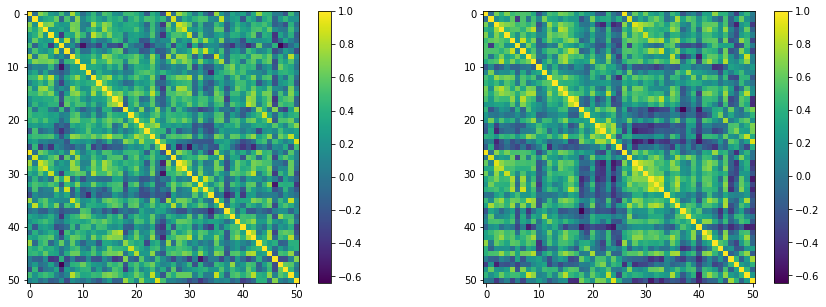

In [40]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cmats[0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cmats[1,:,:])
plt.colorbar()

In [42]:
ofdir = f'~/BC-fMRI-AE/Assets/SFARI-rel-cmats-{pref}'
ofdir = os.path.expanduser(ofdir)

if not os.path.exists(ofdir):
    os.mkdir(ofdir)

In [43]:
ofn = os.path.join(ofdir,f'{sub}-rel-cmats-run-{r}-{pref}.npy')
print(ofn)
np.save(file=ofn,arr=cmats)

/data/aglinska/BC-fMRI-AE/Assets/SFARI-rel-cmats-frc/sub-001-rel-cmats-frc.npy


In [51]:
ofdir = f'~/BC-fMRI-AE/Assets/SFARI-cmats-{pref}'
ofdir = os.path.expanduser(ofdir)

if not os.path.exists(ofdir):
    os.mkdir(ofdir)
    
ofn = os.path.join(ofdir,f'{sub}-cmat-run-{r}-{pref}.npy')
print(ofn)
np.save(file=ofn,arr=cmat)

/data/aglinska/BC-fMRI-AE/Assets/SFARI-cmats-frc/sub-001-cmat-frc.npy
